In [2]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import fbeta_score, precision_recall_curve, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# XGBoost
from xgboost import XGBClassifier

# Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Misc
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


## Load Data

In [5]:
train_path = "X_train.csv"   # <-- adjust paths if needed
y_path     = "y_train.csv"
test_path  = "X_test.csv"

X = pd.read_csv(train_path)
y = pd.read_csv(y_path)
X_test = pd.read_csv(test_path)

print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("X_test:", X_test.shape)

Shapes:
X: (60000, 170)
y: (60000, 2)
X_test: (16000, 170)


## Convert "na" --> np.nan

In [6]:
X = X.replace("na", np.nan)
X_test = X_test.replace("na", np.nan)

# Convert to floats
X = X.astype(float)
X_test = X_test.astype(float)

## Class Imbalance

In [7]:
print(y['Prediction'].value_counts())

neg = y['Prediction'].value_counts()['neg']
pos = y['Prediction'].value_counts()['pos']
scale_pos_weight = neg / pos

print(f"\nscale_pos_weight ≈ {scale_pos_weight:.2f}") # for XGBoost

Prediction
neg    58914
pos     1086
Name: count, dtype: int64

scale_pos_weight ≈ 54.25


## Missing Values

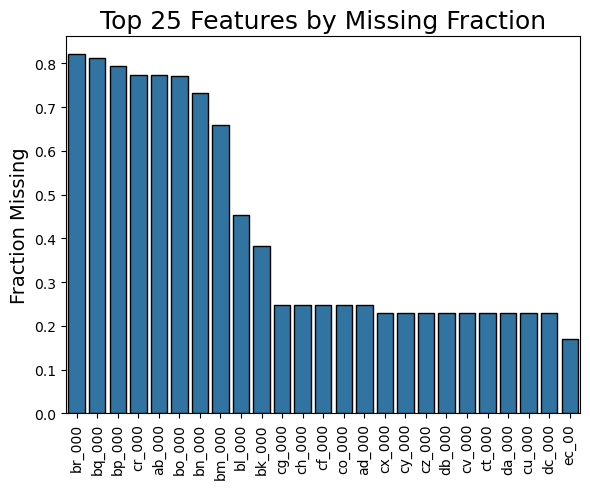

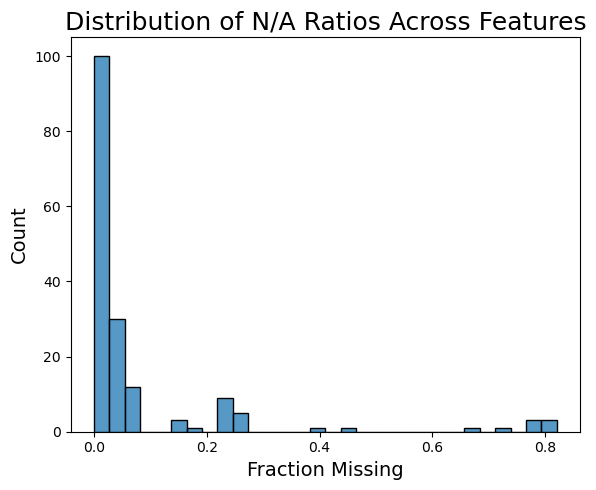

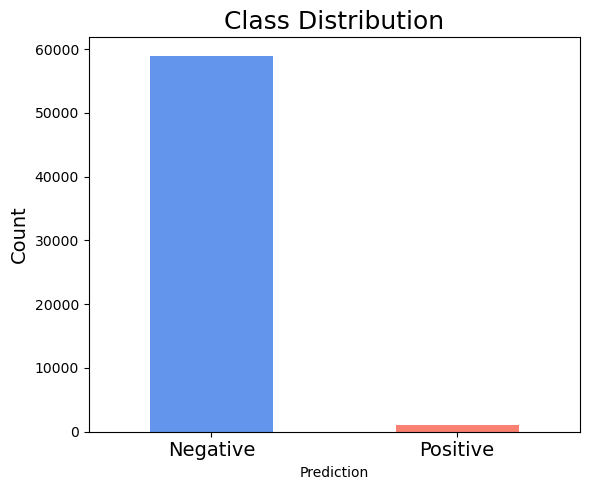

In [8]:
missing_frac = X.isna().mean().sort_values(ascending=False)
missing_frac.head(20)

# Plot missing value fractions
top = missing_frac.head(25).reset_index()
top.columns = ["feature", "missing_frac"]

fig_top25 = plt.figure(figsize=(6,5))
sns.barplot(
    data=top,
    x="feature",
    y="missing_frac",
    color=sns.color_palette()[0],
    edgecolor="black"
)
plt.xticks(rotation=90)
plt.title("Top 25 Features by Missing Fraction", fontsize=18)
plt.ylabel("Fraction Missing", fontsize=14)
plt.xlabel("")
plt.tight_layout()
fig_top25.savefig("pics/top25.png", dpi=600)
plt.show()


fig_frac_missing = plt.figure(figsize=(6,5))
sns.histplot(missing_frac, bins=30)
plt.title("Distribution of N/A Ratios Across Features", fontsize=18)
plt.xlabel("Fraction Missing", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
fig_frac_missing.savefig("pics/frac_missing.png", dpi=600)
plt.show()

fig_class_imbalance = plt.figure(figsize=(6,5))
y['Prediction'].value_counts().plot(kind='bar', color=['cornflowerblue','salmon'])
plt.xticks([0,1], ['Negative','Positive'], rotation=0, fontsize=14)
plt.title("Class Distribution", fontsize=18)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
fig_class_imbalance.savefig("pics/class_imbalance.png", dpi=600)
plt.show()


## Drop extremely sparse features

In [9]:
# Thresholds for the two pipelines
thr_kbest = 0.30   # only use relatively dense features for KBest
thr_xgb   = 0.95   # keep almost everything for XGBoost-based pipeline

cols_kbest = missing_frac[missing_frac <= thr_kbest].index
cols_xgb   = missing_frac[missing_frac <= thr_xgb].index

print(f"Features for KBest pipeline (<= {thr_kbest*100:.0f}% missing): {len(cols_kbest)}")
print(f"Features for XGB/SFM pipeline (<= {thr_xgb*100:.0f}% missing): {len(cols_xgb)}")


Features for KBest pipeline (<= 30% missing): 160
Features for XGB/SFM pipeline (<= 95% missing): 170


#### Feature Density Plot

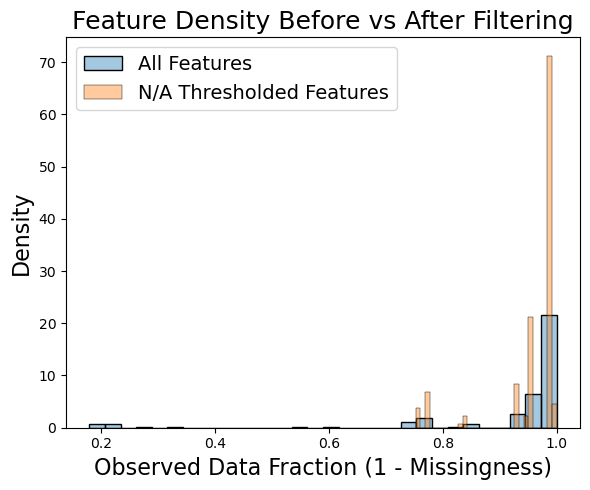

In [10]:
fig_missing_density, ax = plt.subplots(figsize=(6, 5))

sns.histplot(
    1 - missing_frac,
    bins=30,
    stat="density",
    alpha=0.4,
    ax=ax,
    label="All Features"
)

sns.histplot(
    1 - missing_frac[cols_kbest],
    bins=30,
    stat="density",
    alpha=0.4,
    ax=ax,
    label="N/A Thresholded Features"
)

ax.set_xlabel("Observed Data Fraction (1 - Missingness)", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.set_title("Feature Density Before vs After Filtering", fontsize=18)
ax.legend(fontsize=14)

fig_missing_density.tight_layout()
fig_missing_density.savefig("pics/missing_density.png", dpi=600)
plt.show()


## Single train-validation split, then branch per pipeline

In [11]:
from sklearn.model_selection import train_test_split

y['Prediction'] = y['Prediction'].map({'neg': 0, 'pos': 1})

# Single split so both pipelines see exactly the same instances
X_train_all, X_val_all, y_train, y_val = train_test_split(
    X, y['Prediction'],
    test_size=0.20,
    stratify=y['Prediction'],
    random_state=RANDOM_STATE
)

print("Overall Train:", X_train_all.shape)
print("Overall Val:  ", X_val_all.shape)

# Now create pipeline-specific views
Xk_train = X_train_all[cols_kbest].copy()
Xk_val   = X_val_all[cols_kbest].copy()

Xx_train = X_train_all[cols_xgb].copy()
Xx_val   = X_val_all[cols_xgb].copy()

# Also prepare test matrices for later
Xk_test = X_test[cols_kbest].copy()
Xx_test = X_test[cols_xgb].copy()

print("KBest Train shape:", Xk_train.shape)
print("SFM/XGB Train shape:", Xx_train.shape)


Overall Train: (48000, 170)
Overall Val:   (12000, 170)
KBest Train shape: (48000, 160)
SFM/XGB Train shape: (48000, 170)


## Pipelines

I will train 9 pipelines.
- Three will use XGBoost, but with different feature selection approaches:
    - Pipeline XGB-SKB_120 will use sklearn's SelectKBest() method with max feature num = 120
    - Pipeline XGB-SKB_160 will use sklearn's SelectKBest() method with max feature num = 160
    - Pipeline XGB-SFM will use sklearn's SelectFromModel() method, with XGBoost as the model
- Two will use a Logit classifier:
    - Pipeline Logit_120 with max selectable feature num. for SelectKBest = 120
    - Pipeline Logit_160 with max selectable feature num. for SelectKBest = 160
- Two will use an SVM classifier:
    - Pipeline SVM_120 with max selectable feature num. for SelectKBest = 120
    - Pipeline SVM_160 with max selectable feature num. for SelectKBest = 160
- Two will use a Decision Tree:
    - Pipeline Dec-Tree_120 with max selectable feature num. for SelectKBest = 120
    - Pipeline Dec-Tree_160 with max selectable feature num. for SelectKBest = 160

### Pipeline XGB-SKB_120

In [ ]:
# -------- Pipeline XGB-SKB_120: SelectKBest + XGBoost --------
pipe_kbest = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # handle NaNs
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", XGBClassifier(
        tree_method="hist",
        #predictor="gpu_predictor",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    )),
])

search_kbest = {
    "select__k": Integer(20, min(120, len(cols_kbest))),  # sanity upper bound
    "clf__max_depth": Integer(3, 10),
    "clf__learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__min_child_weight": Integer(1, 10),
    "clf__gamma": Real(0.0, 5.0),
}

opt_kbest = BayesSearchCV(
    estimator=pipe_kbest,
    search_spaces=search_kbest,
    n_iter=40,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting KBest + XGBoost pipeline...")
opt_kbest.fit(Xk_train, y_train)
print("Best KBest params:", opt_kbest.best_params_)

pred_kb  = opt_kbest.best_estimator_.predict(Xk_val)
ba_kb  = balanced_accuracy_score(y_val, pred_kb)
print("Balanced Accuracy (KBest pipeline):       ", ba_kb)
print("\n=== KBest Classification Report ===")
print(classification_report(y_val, pred_kb))

# Below is a SelectKBest-XGBoost Pipeline devised after the Kaggle Submission deadline. This pipeline achieves slightly better ba score on the validation set,
# but is not presented in the report as it was not part of the code when the Kaggle submission occured. The difference is a wider learning_rate search.
# If you uncomment the sections below, you can run this model as well.

'''# -------- Pipeline A: SelectKBest + XGBoost --------
pipe_kbest = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # handle NaNs
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", XGBClassifier(
        tree_method="hist",
        #predictor="gpu_predictor",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    )),
])

search_kbest = {
    "select__k": Integer(20, min(120, len(cols_kbest))),  # sanity upper bound
    "clf__max_depth": Integer(3, 10),
    "clf__learning_rate": Real(0.001, 0.3, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__min_child_weight": Integer(1, 10),
    "clf__gamma": Real(0.0, 5.0),
}

opt_kbest = BayesSearchCV(
    estimator=pipe_kbest,
    search_spaces=search_kbest,
    n_iter=40,              # adjust if needed
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting KBest + XGBoost pipeline...")
opt_kbest.fit(Xk_train, y_train)
print("Best KBest params:", opt_kbest.best_params_)

from skopt.plots import plot_objective
_ = plot_objective(opt_kbest.optimizer_results_[0],
                   dimensions=["k", "max_depth", "learning_rate", "subsample", "colsample_bytree", "min_child_weight", "gamma"],
                   n_minimum_search=int(1e8))
plt.show()
'''


Fitting KBest + XGBoost pipeline...
Best KBest params: OrderedDict({'clf__colsample_bytree': 0.5, 'clf__gamma': 5.0, 'clf__learning_rate': 0.07033543604307806, 'clf__max_depth': 3, 'clf__min_child_weight': 10, 'clf__subsample': 0.5, 'select__k': 120})
Balanced Accuracy (KBest pipeline):        0.9509804995167997

=== KBest Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11783
           1       0.34      0.94      0.50       217

    accuracy                           0.97     12000
   macro avg       0.67      0.95      0.74     12000
weighted avg       0.99      0.97      0.97     12000



'# -------- Pipeline A: SelectKBest + XGBoost --------\npipe_kbest = Pipeline([\n    ("imputer", SimpleImputer(strategy="median")),   # handle NaNs\n    ("scaler", StandardScaler()),\n    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned\n    ("clf", XGBClassifier(\n        tree_method="hist",\n        #predictor="gpu_predictor",\n        random_state=RANDOM_STATE,\n        n_jobs=-1,\n        eval_metric="logloss",\n        scale_pos_weight=scale_pos_weight\n    )),\n])\n\nsearch_kbest = {\n    "select__k": Integer(20, min(120, len(cols_kbest))),  # sanity upper bound\n    "clf__max_depth": Integer(3, 10),\n    "clf__learning_rate": Real(0.001, 0.3, prior="log-uniform"),\n    "clf__subsample": Real(0.5, 1.0),\n    "clf__colsample_bytree": Real(0.5, 1.0),\n    "clf__min_child_weight": Integer(1, 10),\n    "clf__gamma": Real(0.0, 5.0),\n}\n\nopt_kbest = BayesSearchCV(\n    estimator=pipe_kbest,\n    search_spaces=search_kbest,\n    n_iter=40,              # adjust if neede

### Pipeline XGB-SKB_160

In [ ]:
# -------- Pipeline XGB-SKB_160: SelectKBest + XGBoost --------
pipe_kbest_160 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # handle NaNs
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", XGBClassifier(
        tree_method="hist",
        #predictor="gpu_predictor",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    )),
])

search_kbest_160 = {
    "select__k": Integer(20, 160),  # sanity upper bound
    "clf__max_depth": Integer(3, 10),
    "clf__learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__min_child_weight": Integer(1, 10),
    "clf__gamma": Real(0.0, 5.0),
}

opt_kbest_160 = BayesSearchCV(
    estimator=pipe_kbest_160,
    search_spaces=search_kbest_160,
    n_iter=40,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting KBest + XGBoost pipeline...")
opt_kbest_160.fit(Xk_train, y_train)
print("Best KBest params:", opt_kbest_160.best_params_)

pred_kb_160  = opt_kbest_160.best_estimator_.predict(Xk_val)
ba_kb_160  = balanced_accuracy_score(y_val, pred_kb_160)
print("Balanced Accuracy (KBest pipeline):       ", ba_kb_160)
print("\n=== KBest Classification Report ===")
print(classification_report(y_val, pred_kb_160))

Fitting KBest + XGBoost pipeline...
Best KBest params: OrderedDict({'clf__colsample_bytree': 0.5, 'clf__gamma': 0.0, 'clf__learning_rate': 0.06724234006501363, 'clf__max_depth': 3, 'clf__min_child_weight': 10, 'clf__subsample': 1.0, 'select__k': 160})
Balanced Accuracy (KBest pipeline):        0.9476579356888057

=== KBest Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     11783
           1       0.33      0.93      0.48       217

    accuracy                           0.96     12000
   macro avg       0.66      0.95      0.73     12000
weighted avg       0.99      0.96      0.97     12000



### Pipeline XGB-SFM

In [21]:
# -------- Pipeline XGB-SFM: SelectFromModel(XGB) + XGBoost --------

# XGB model for feature selection
xgb_fs = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

pipe_sfm = Pipeline([
    # no imputer, no scaler — let XGB see the raw NaN pattern
    ("select", SelectFromModel(estimator=xgb_fs, threshold="median")),
    ("clf", XGBClassifier(
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    )),
])

search_sfm = {
    "clf__max_depth": Integer(3, 10),
    "clf__learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__min_child_weight": Integer(1, 10),
    "clf__gamma": Real(0.0, 5.0),
}

opt_sfm = BayesSearchCV(
    estimator=pipe_sfm,
    search_spaces=search_sfm,
    n_iter=40,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting SelectFromModel + XGBoost pipeline...")
opt_sfm.fit(Xx_train, y_train)
print("Best SFM params:", opt_sfm.best_params_)

pred_sfm = opt_sfm.best_estimator_.predict(Xx_val)
ba_sfm = balanced_accuracy_score(y_val, pred_sfm)

print("Balanced Accuracy (SelectFromModel pipeline):", ba_sfm)
print("\n=== SelectFromModel Classification Report ===")
print(classification_report(y_val, pred_sfm))

Fitting SelectFromModel + XGBoost pipeline...
Best SFM params: OrderedDict({'clf__colsample_bytree': 0.5, 'clf__gamma': 3.9342551344179197, 'clf__learning_rate': 0.05083281306524363, 'clf__max_depth': 4, 'clf__min_child_weight': 10, 'clf__subsample': 1.0})
Balanced Accuracy (SelectFromModel pipeline): 0.9462321918909185

=== SelectFromModel Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11783
           1       0.37      0.92      0.53       217

    accuracy                           0.97     12000
   macro avg       0.68      0.95      0.76     12000
weighted avg       0.99      0.97      0.98     12000



## Choose best pipeline and train on full train + valid data
- This selection below pertains to the original code, the finalized version will handle model selection properly and will be uploaded to the January moodle deadline submission page

In [45]:
# Full design matrices for final training
X_kbest_full = X[cols_kbest].copy()
X_xgb_full   = X[cols_xgb].copy()

# Choose model
if ba_sfm > ba_kb:
    print("\nUsing SelectFromModel pipeline for final training.")
    final_pipe = opt_sfm.best_estimator_
    X_train_final = X_xgb_full
    X_test_final  = Xx_test
else:
    print("\nUsing KBest pipeline for final training.")
    final_pipe = opt_kbest.best_estimator_
    X_train_final = X_kbest_full
    X_test_final  = Xk_test

# Fit on all available labelled data
final_pipe.fit(X_train_final, y['Prediction'])



Using KBest pipeline for final training.


,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [46]:
print(final_pipe.named_steps['clf'])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=5.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07033543604307806,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)


In [47]:
print("Final model:", final_pipe)
print("Number of features used:", final_pipe.named_steps['select'].k)
preds = final_pipe.predict(X_train_final)
print("Balanced accuracy on full training:", balanced_accuracy_score(y['Prediction'], preds))


Final model: Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('select', SelectKBest(k=120)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=...
                               gamma=5.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07033543604307806, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
              

In [ ]:
y_test_pred = final_pipe.predict(X_test_final)

# Convert predictions to original labels
y_test_pred = np.where(y_test_pred == 1, 'pos', 'neg')

submission = pd.DataFrame({
    "Id": np.arange(len(y_test_pred)),
    "Prediction": y_test_pred
})

submission.to_csv("my_submission2.csv", index=False)
print("Saved my_submission2.csv")


Saved my_submission2.csv


## Training Some Simpler Models
- Logit()
- SVM
- DecisionTreeClassifier

### Logit_120 Pipeline

In [19]:
pipe_logit = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", LogisticRegression(
        penalty="l2",
        class_weight="balanced",
        max_iter=500,
        solver="lbfgs",
        n_jobs=-1,
        random_state=RANDOM_STATE
    )),
])

search_logit = {
    "select__k": Integer(20, 120),
    "clf__C": Real(1e-3, 1e2, prior="log-uniform"),
}

opt_logit = BayesSearchCV(
    estimator=pipe_logit,
    search_spaces=search_logit,
    n_iter=40,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting Logistic Regression pipeline...")
opt_logit.fit(Xk_train, y_train)

print("Best Logit params:", opt_logit.best_params_)

pred_logit = opt_logit.best_estimator_.predict(Xk_val)
ba_logit   = balanced_accuracy_score(y_val, pred_logit)

print("Balanced Accuracy (Logit):", ba_logit)
print("\n=== Logistic Regression Classification Report ===")
print(classification_report(y_val, pred_logit))



Fitting Logistic Regression pipeline...
Best Logit params: OrderedDict({'clf__C': 0.0011668100942033093, 'select__k': 120})
Balanced Accuracy (Logit): 0.9299631469378481

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11783
           1       0.40      0.88      0.55       217

    accuracy                           0.97     12000
   macro avg       0.70      0.93      0.77     12000
weighted avg       0.99      0.97      0.98     12000



### Logit_160 Pipeline

In [20]:
pipe_logit_160 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", LogisticRegression(
        penalty="l2",
        class_weight="balanced",
        max_iter=500,
        solver="lbfgs",
        n_jobs=-1,
        random_state=RANDOM_STATE
    )),
])

search_logit_160 = {
    "select__k": Integer(20, 160),
    "clf__C": Real(1e-3, 1e2, prior="log-uniform"),
}

opt_logit_160 = BayesSearchCV(
    estimator=pipe_logit_160,
    search_spaces=search_logit_160,
    n_iter=40,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting Logistic Regression pipeline...")
opt_logit_160.fit(Xk_train, y_train)

print("Best Logit params:", opt_logit_160.best_params_)

pred_logit_160 = opt_logit_160.best_estimator_.predict(Xk_val)
ba_logit_160   = balanced_accuracy_score(y_val, pred_logit_160)

print("Balanced Accuracy (Logit):", ba_logit_160)
print("\n=== Logistic Regression Classification Report ===")
print(classification_report(y_val, pred_logit_160))

Fitting Logistic Regression pipeline...
Best Logit params: OrderedDict({'clf__C': 0.005060602202203271, 'select__k': 160})
Balanced Accuracy (Logit): 0.924238856964517

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11783
           1       0.42      0.87      0.56       217

    accuracy                           0.98     12000
   macro avg       0.71      0.92      0.78     12000
weighted avg       0.99      0.98      0.98     12000



### SVM_120 Pipeline

In [ ]:
pipe_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

search_svm = {
    "select__k": Integer(20, 120),
    "clf__C": Real(1e-3, 1e1, prior="log-uniform"),
}

opt_svm = BayesSearchCV(
    estimator=pipe_svm,
    search_spaces=search_svm,
    n_iter=15,
    cv=4,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting Linear SVM pipeline...")
opt_svm.fit(Xk_train, y_train)

print("Best SVM params:", opt_svm.best_params_)

pred_svm = opt_svm.best_estimator_.predict(Xk_val)
ba_svm   = balanced_accuracy_score(y_val, pred_svm)

print("Balanced Accuracy (Linear SVM):", ba_svm)
print("\n=== Linear SVM Classification Report ===")
print(classification_report(y_val, pred_svm))


Fitting Linear SVM pipeline...
Best SVM params: OrderedDict({'clf__C': 0.0010340016434251915, 'select__k': 102})
Balanced Accuracy (Linear SVM): 0.9196305620336414

=== Linear SVM Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11783
           1       0.41      0.86      0.56       217

    accuracy                           0.98     12000
   macro avg       0.71      0.92      0.77     12000
weighted avg       0.99      0.98      0.98     12000



### SVM_160 Pipeline

In [23]:
pipe_svm_160 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

search_svm_160 = {
    "select__k": Integer(20, 160),
    "clf__C": Real(1e-3, 1e1, prior="log-uniform"),
}

opt_svm_160 = BayesSearchCV(
    estimator=pipe_svm_160,
    search_spaces=search_svm_160,
    n_iter=15,
    cv=4,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting Linear SVM pipeline...")
opt_svm_160.fit(Xk_train, y_train)

print("Best SVM params:", opt_svm_160.best_params_)

pred_svm_160 = opt_svm_160.best_estimator_.predict(Xk_val)
ba_svm_160   = balanced_accuracy_score(y_val, pred_svm_160)

print("Balanced Accuracy (Linear SVM):", ba_svm_160)
print("\n=== Linear SVM Classification Report ===")
print(classification_report(y_val, pred_svm_160))

Fitting Linear SVM pipeline...
Best SVM params: OrderedDict({'clf__C': 0.002476680893025569, 'select__k': 65})
Balanced Accuracy (Linear SVM): 0.9140038507402095

=== Linear SVM Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11783
           1       0.39      0.85      0.54       217

    accuracy                           0.97     12000
   macro avg       0.69      0.91      0.76     12000
weighted avg       0.99      0.97      0.98     12000



### DecisionTreeClassifier

### Dec-Tree_120

In [24]:
pipe_dt = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

search_dt = {
    "select__k": Integer(20, 120),
    "clf__max_depth": Integer(2, 12),
    "clf__min_samples_leaf": Integer(1, 50),
    "clf__min_samples_split": Integer(2, 50),
}

opt_dt = BayesSearchCV(
    estimator=pipe_dt,
    search_spaces=search_dt,
    n_iter=50,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting Decision Tree pipeline...")
opt_dt.fit(Xk_train, y_train)

print("Best DT params:", opt_dt.best_params_)

pred_dt = opt_dt.best_estimator_.predict(Xk_val)
ba_dt   = balanced_accuracy_score(y_val, pred_dt)

print("Balanced Accuracy (Decision Tree):", ba_dt)
print("\n=== Decision Tree Classification Report ===")
print(classification_report(y_val, pred_dt))


Fitting Decision Tree pipeline...
Best DT params: OrderedDict({'clf__max_depth': 5, 'clf__min_samples_leaf': 50, 'clf__min_samples_split': 50, 'select__k': 46})
Balanced Accuracy (Decision Tree): 0.9367821171718531

=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     11783
           1       0.24      0.93      0.39       217

    accuracy                           0.95     12000
   macro avg       0.62      0.94      0.68     12000
weighted avg       0.98      0.95      0.96     12000



### Dec-Tree_160

In [25]:
pipe_dt_160 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

search_dt_160 = {
    "select__k": Integer(20, 160),
    "clf__max_depth": Integer(2, 12),
    "clf__min_samples_leaf": Integer(1, 50),
    "clf__min_samples_split": Integer(2, 50),
}

opt_dt_160 = BayesSearchCV(
    estimator=pipe_dt_160,
    search_spaces=search_dt_160,
    n_iter=50,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting Decision Tree pipeline...")
opt_dt_160.fit(Xk_train, y_train)

print("Best DT params:", opt_dt_160.best_params_)

pred_dt_160 = opt_dt_160.best_estimator_.predict(Xk_val)
ba_dt_160   = balanced_accuracy_score(y_val, pred_dt_160)

print("Balanced Accuracy (Decision Tree):", ba_dt_160)
print("\n=== Decision Tree Classification Report ===")
print(classification_report(y_val, pred_dt_160))


Fitting Decision Tree pipeline...
Best DT params: OrderedDict({'clf__max_depth': 5, 'clf__min_samples_leaf': 34, 'clf__min_samples_split': 50, 'select__k': 49})
Balanced Accuracy (Decision Tree): 0.9395530388034624

=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     11783
           1       0.25      0.93      0.39       217

    accuracy                           0.95     12000
   macro avg       0.62      0.94      0.68     12000
weighted avg       0.99      0.95      0.96     12000



## Analysis of Different Models

### Hyperparameters - Report Tables I. and II.
- XGB Models

In [ ]:
# Grab the best params dicts
kb_params     = dict(opt_kbest.best_params_)
kb160_params  = dict(opt_kbest_160.best_params_)
sfm_params    = dict(opt_sfm.best_params_)

# Make a row per model (add a Model name column)
rows = [
    {"Model": "XGBoost-SKB (k≤120)", **kb_params},
    {"Model": "XGBoost-SKB (k≤160)", **kb160_params},
    {"Model": "XGBoost-SFM",         **sfm_params},
]

# Create table with all hyperparameter keys as columns
df = pd.DataFrame(rows)

# Nicer column order (Model first, then sorted params)
cols = ["Model"] + sorted([c for c in df.columns if c != "Model"])
df = df[cols]

# Round floats for readability
for c in df.columns:
    if df[c].dtype.kind in "fc":   # float/complex
        df[c] = df[c].round(6)

# Save to CSV
df.to_csv("best_xgb_hyperparams_table.csv", index=False)
print("Saved: best_xgb_hyperparams_table.csv")

# Print LaTeX directly
print(df.to_latex(index=False, float_format="%.6f"))


Saved: best_xgb_hyperparams_table.csv
\begin{tabular}{lrrrrrrr}
\toprule
Model & clf__colsample_bytree & clf__gamma & clf__learning_rate & clf__max_depth & clf__min_child_weight & clf__subsample & select__k \\
\midrule
XGBoost-SKB (k≤120) & 0.500000 & 5.000000 & 0.070335 & 3 & 10 & 0.500000 & 120.000000 \\
XGBoost-SKB (k≤160) & 0.500000 & 0.000000 & 0.067242 & 3 & 10 & 1.000000 & 160.000000 \\
XGBoost-SFM & 0.500000 & 3.934255 & 0.050833 & 4 & 10 & 1.000000 & NaN \\
\bottomrule
\end{tabular}



- Simpler Classifiers

In [ ]:
# Typed it in by hand - not many entries

### Scores - Report Table III.

In [ ]:
def compute_metrics(y_true, y_pred):
    """
    Returns metrics for binary classification where positive class is 1.
    """
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    # Avoid division by zero safely
    def safe_div(a, b):
        return a / b if b != 0 else np.nan

    sensitivity = safe_div(tp, tp + fn)          # TPR / Recall+
    specificity = safe_div(tn, tn + fp)          # TNR
    precision   = safe_div(tp, tp + fp)          # PPV
    f1          = safe_div(2 * precision * sensitivity, precision + sensitivity)

    accuracy    = safe_div(tp + tn, tp + tn + fp + fn)
    error_rate  = 1 - accuracy
    bal_acc     = 0.5 * (sensitivity + specificity)

    return {
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "BalancedAccuracy": bal_acc,
        "Precision": precision,
        "F1": f1,
        "SuccessRate": accuracy,
        "ErrorRate": error_rate
    }

models = {
    "XGBoost-SKB (k≤120)": pred_kb,
    "XGBoost-SKB (k≤160)": pred_kb_160,
    "XGBoost-SFM":         pred_sfm,
    "Logit (k≤120)":       pred_logit,
    "Logit (k≤160)":       pred_logit_160,
    "SVM (k≤120)":         pred_svm,
    "SVM (k≤160)":         pred_svm_160,
    "DecisionTree (k≤120)": pred_dt,
    "DecisionTree (k≤160)": pred_dt_160,
}

rows = []
for name, pred in models.items():
    m = compute_metrics(y_val, pred)
    m["Model"] = name
    m["RunTimeSec"] = ""
    rows.append(m)

df_metrics = pd.DataFrame(rows)

# Reorder columns
df_metrics = df_metrics[[
    "Model",
    "Sensitivity",
    "Specificity",
    "BalancedAccuracy",
    "Precision",
    "F1",
    "SuccessRate",
    "ErrorRate",
    "RunTimeSec"
]]

df_metrics.iloc[:, 1:8] = df_metrics.iloc[:, 1:8].astype(float).round(4)

# Save CSV
df_metrics.to_csv("model_metrics_table.csv", index=False)
print("Saved: model_metrics_table.csv")

# LaTeX table output
print(df_metrics.to_latex(index=False, escape=False))


Saved: model_metrics_table.csv
\begin{tabular}{lrrrrrrrl}
\toprule
Model & Sensitivity & Specificity & BalancedAccuracy & Precision & F1 & SuccessRate & ErrorRate & RunTimeSec \\
\midrule
XGBoost-SKB (k≤120) & 0.935500 & 0.966500 & 0.951000 & 0.339500 & 0.498200 & 0.965900 & 0.034100 &  \\
XGBoost-SKB (k≤160) & 0.930900 & 0.964400 & 0.947700 & 0.325300 & 0.482100 & 0.963800 & 0.036200 &  \\
XGBoost-SFM & 0.921700 & 0.970800 & 0.946200 & 0.367600 & 0.525600 & 0.969900 & 0.030100 &  \\
Logit (k≤120) & 0.884800 & 0.975100 & 0.930000 & 0.395900 & 0.547000 & 0.973500 & 0.026500 &  \\
Logit (k≤160) & 0.871000 & 0.977500 & 0.924200 & 0.416300 & 0.563300 & 0.975600 & 0.024400 &  \\
SVM (k≤120) & 0.861800 & 0.977500 & 0.919600 & 0.413700 & 0.559000 & 0.975400 & 0.024600 &  \\
SVM (k≤160) & 0.852500 & 0.975500 & 0.914000 & 0.390300 & 0.535500 & 0.973200 & 0.026800 &  \\
DecisionTree (k≤120) & 0.926300 & 0.947300 & 0.936800 & 0.244500 & 0.386900 & 0.946900 & 0.053100 &  \\
DecisionTree (k≤160) & 

## Saving Models and Data for Reproducibility

In [1]:
# Get prefix for saved files
import datetime
date = datetime.datetime.now()
date_prefix = f"{date.year}{date.month}{date.day}"
print("Date prefix for saved files:", date_prefix)

Date prefix for saved files: 202614


### Models

In [ ]:
import joblib

# Save the best estimators found by BayesSearchCV
joblib.dump(opt_kbest.best_estimator_, f"model_kbest_pipeline{opt_kbest.best_estimator_.named_steps['select'].k}_{date_prefix}.pkl")
joblib.dump(opt_kbest_160.best_estimator_, f"model_kbest_160_pipeline{opt_kbest_160.best_estimator_.named_steps['select'].k}_{date_prefix}.pkl")
joblib.dump(opt_sfm.best_estimator_, f"model_sfm_pipeline_{date_prefix}.pkl")

joblib.dump(opt_logit.best_estimator_, f"model_logit_pipeline_{date_prefix}.pkl")
joblib.dump(opt_logit_160.best_estimator_, f"model_logit_160_pipeline_{date_prefix}.pkl")

joblib.dump(opt_svm.best_estimator_, f"model_svm_pipeline_{date_prefix}.pkl")
joblib.dump(opt_svm_160.best_estimator_, f"model_svm_160_pipeline_{date_prefix}.pkl")

joblib.dump(opt_dt.best_estimator_, f"model_dectree_pipeline_{date_prefix}.pkl")
joblib.dump(opt_dt_160.best_estimator_, f"model_dectree_160_pipeline_{date_prefix}.pkl")


['model_kbest_pipeline120_2025127.pkl']

### Hyperparameters

In [ ]:
import json

params_to_save = {
    "kbest_best_params": opt_kbest.best_params_,
    "kbest_best_params": opt_kbest_160.best_params_,
    "sfm_best_params": opt_sfm.best_params_,
    "logit_best_params": opt_logit.best_params_,
    "logit_160_best_params": opt_logit_160.best_params_,
    "svm_best_params": opt_svm.best_params_,
    "svm_160_best_params": opt_svm_160.best_params_,
    "dt_best_params": opt_dt.best_params_,
    "dt_160_best_params": opt_dt_160.best_params_,
    "scale_pos_weight": scale_pos_weight,
    "num_features_kbest": int(opt_kbest.best_estimator_.named_steps["select"].k),
    "um_features_sfm": int(len(cols_xgb)),
    "cols_kbest": list(cols_kbest),
    "ols_xgb": list(cols_xgb)
}

with open(f"model_metadata_all_{date_prefix}.json", "w") as f:
    json.dump(params_to_save, f, indent=4)

print(f"model_metadata_all_{date_prefix}.json")


model_metadata_all_2025127.json


### Final Model

In [28]:
joblib.dump(final_pipe, f"final_model_{date_prefix}.pkl")
print(f"Saved: final_model_{date_prefix}.pkl")

Saved: final_model_2025127.pkl


### BayesSearchCV() Results

In [ ]:
df_kbest_cv = pd.DataFrame(opt_kbest.cv_results_)
f_sfm_cv   = pd.DataFrame(opt_sfm.cv_results_)

df_kbest_cv.to_csv(f"kbest_cv_results{opt_kbest.best_estimator_.named_steps['select'].k}_{date_prefix}.csv", index=False)
f_sfm_cv.to_csv(f"sfm_cv_results_{date_prefix}.csv", index=False)

print(f"Saved: kbest_cv_results_{date_prefix}.csv, sfm_cv_results_{date_prefix}.csv")


Saved: kbest_cv_results_2025128.csv, sfm_cv_results_2025128.csv


## Disclaimer
When first saving the models (on November 27, 2025) I wrote the date into the file names by hand and accidentally wrote *2025127* instead of *20251127*. That is why the date prefixes in the saved files in Materials_mentioned_in_Report refer to 2025127 instead of the actual date. This is also the reason why some cells above do not have their outputs or have different outputs then what they are supposed to have based on the code in them.